# Import Libraries

In [1]:
import os
os.environ["KERAS_BACKEND"] = "jax"  # "jax" or "tensorflow" or "torch" 

import keras_cv
import keras
import keras.backend as K
import tensorflow as tf
import tensorflow_io as tfio

import numpy as np 
import pandas as pd

from glob import glob
from tqdm import tqdm

import librosa
import IPython.display as ipd
import librosa.display as lid

import matplotlib.pyplot as plt
import matplotlib as mpl

cmap = mpl.cm.get_cmap('coolwarm')

2025-05-23 16:39:18.180288: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-23 16:39:18.180401: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-23 16:39:18.305995: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
/tmp/ipykernel_24/3165360914.py:23: MatplotlibDeprecationWarning: The get_cmap function was deprecated in Matplotlib 3.7 and will be removed two minor releases later. Use ``matplotlib.colormaps[name]`` or ``matplotlib.colormaps.get_cmap(obj)`` instead.
  cmap = mpl.cm.get_cmap('coolwarm')


## Library Version

In [2]:
print("TensorFlow:", tf.__version__)
print("Keras:", keras.__version__)
print("KerasCV:", keras_cv.__version__)

TensorFlow: 2.15.0
Keras: 3.2.1
KerasCV: 0.8.2


# Configuration

In [3]:
class CFG:
    seed = 42
    
    # Input image size and batch size
    img_size = [128, 384]
    batch_size = 64
    
    # Audio duration, sample rate, and length
    duration = 15 # second
    sample_rate = 32000
    audio_len = duration*sample_rate
    
    # STFT parameters
    nfft = 2028
    window = 2048
    hop_length = audio_len // (img_size[1] - 1)
    fmin = 20
    fmax = 16000
    
    # Number of epochs, model name
    epochs = 10
    preset = 'efficientnetv2_b2_imagenet'
    
    # Data augmentation parameters
    augment=True

    # Class Labels for BirdCLEF 25
    class_names = sorted(os.listdir('/kaggle/input/birdclef-2025/train_audio/'))
    num_classes = len(class_names)
    class_labels = list(range(num_classes))
    label2name = dict(zip(class_labels, class_names))
    name2label = {v:k for k,v in label2name.items()}

# Reproducibility 
Sets value for random seed to produce similar result in each run.

In [4]:
tf.keras.utils.set_random_seed(CFG.seed)

# Dataset Path

In [5]:
BASE_PATH = '/kaggle/input/birdclef-2025'

# Meta Data 

In [6]:
df = pd.read_csv(f'{BASE_PATH}/train.csv')
df['filepath'] = BASE_PATH + '/train_audio/' + df.filename
df['target'] = df.primary_label.map(CFG.name2label)
df['filename'] = df.filepath.map(lambda x: x.split('/')[-1])
df['xc_id'] = df.filepath.map(lambda x: x.split('/')[-1].split('.')[0])

# Display rows
df.head(2)

primary_label secondary_labels  type      filename collection  rating  \
0       1139490             ['']  ['']  CSA36385.ogg        CSA     0.0   
1       1139490             ['']  ['']  CSA36389.ogg        CSA     0.0   

                                                 url  latitude  longitude  \
0  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   -73.7128   
1  http://colecciones.humboldt.org.co/rec/sonidos...    7.3206   -73.7128   

        scientific_name           common_name             author  \
0  Ragoniella pulchella  Ragoniella pulchella  Fabio A. Sarria-S   
1  Ragoniella pulchella  Ragoniella pulchella  Fabio A. Sarria-S   

           license                                           filepath  target  \
0  cc-by-nc-sa 4.0  /kaggle/input/birdclef-2025/train_audio/113949...       0   
1  cc-by-nc-sa 4.0  /kaggle/input/birdclef-2025/train_audio/113949...       0   

      xc_id  
0  CSA36385  
1  CSA36389

# EDA 

## Utility

In [7]:
def load_audio(filepath):
    audio, sr = librosa.load(filepath)
    return audio, sr

def get_spectrogram(audio):
    spec = librosa.feature.melspectrogram(y=audio, 
                                   sr=CFG.sample_rate, 
                                   n_mels=256,
                                   n_fft=2048,
                                   hop_length=512,
                                   fmax=CFG.fmax,
                                   fmin=CFG.fmin,
                                   )
    spec = librosa.power_to_db(spec, ref=1.0)
    min_ = spec.min()
    max_ = spec.max()
    if max_ != min_:
        spec = (spec - min_)/(max_ - min_)
    return spec

def display_audio(row):
    # Caption for viz
    caption = f'Id: {row.filename} | Name: {row.common_name} | Sci.Name: {row.scientific_name} | Rating: {row.rating}'
    # Read audio file
    audio, sr = load_audio(row.filepath)
    # Keep fixed length audio
    audio = audio[:CFG.audio_len]
    # Spectrogram from audio
    spec = get_spectrogram(audio)
    # Display audio
    print("# Audio:")
    display(ipd.Audio(audio, rate=CFG.sample_rate))
    print('# Visualization:')
    fig, ax = plt.subplots(2, 1, figsize=(12, 2*3), sharex=True, tight_layout=True)
    fig.suptitle(caption)
    # Waveplot
    lid.waveshow(audio,
                 sr=CFG.sample_rate,
                 ax=ax[0],
                 color= cmap(0.1))
    # Specplot
    lid.specshow(spec, 
                 sr = CFG.sample_rate, 
                 hop_length=512,
                 n_fft=2048,
                 fmin=CFG.fmin,
                 fmax=CFG.fmax,
                 x_axis = 'time', 
                 y_axis = 'mel',
                 cmap = 'coolwarm',
                 ax=ax[1])
    ax[0].set_xlabel('');
    fig.show()

## Sample 1

# Audio:


# Visualization:


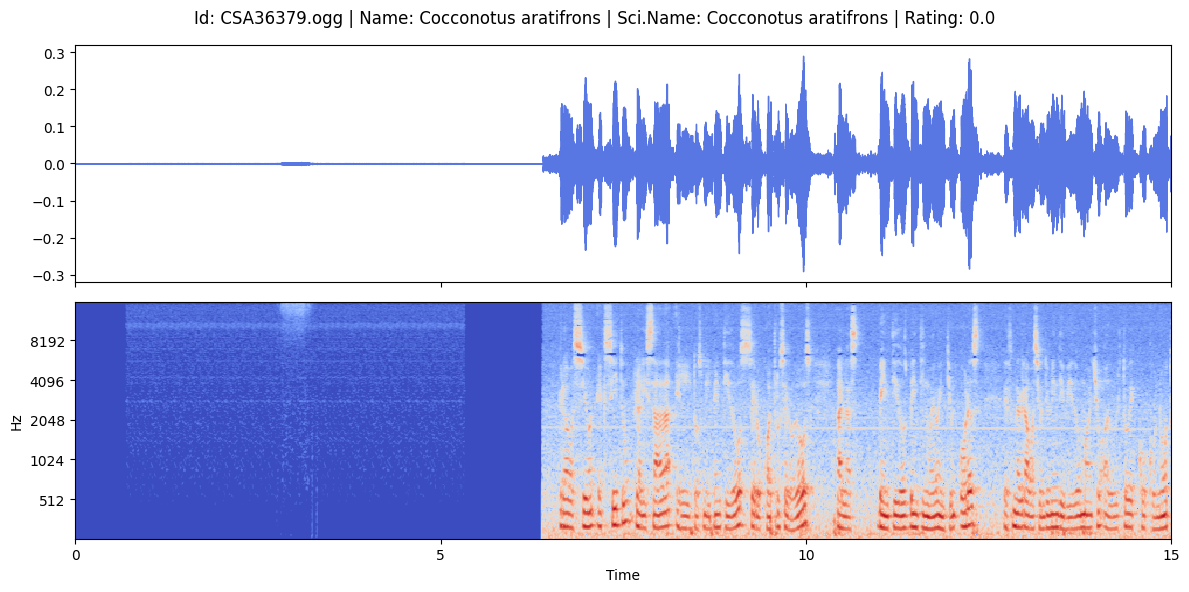

In [8]:
row = df.iloc[35]

# Display audio
display_audio(row)

## Sample 2

# Audio:


# Visualization:


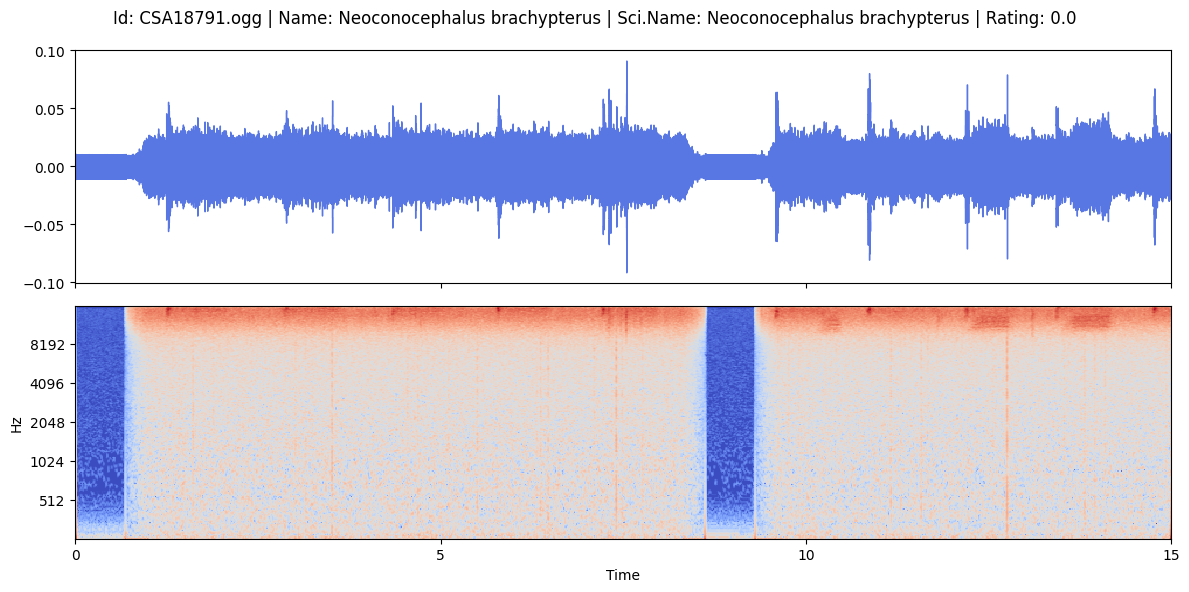

In [9]:
row = df.iloc[16]

# Display audio
display_audio(row)

## Sample 3

# Audio:


# Visualization:


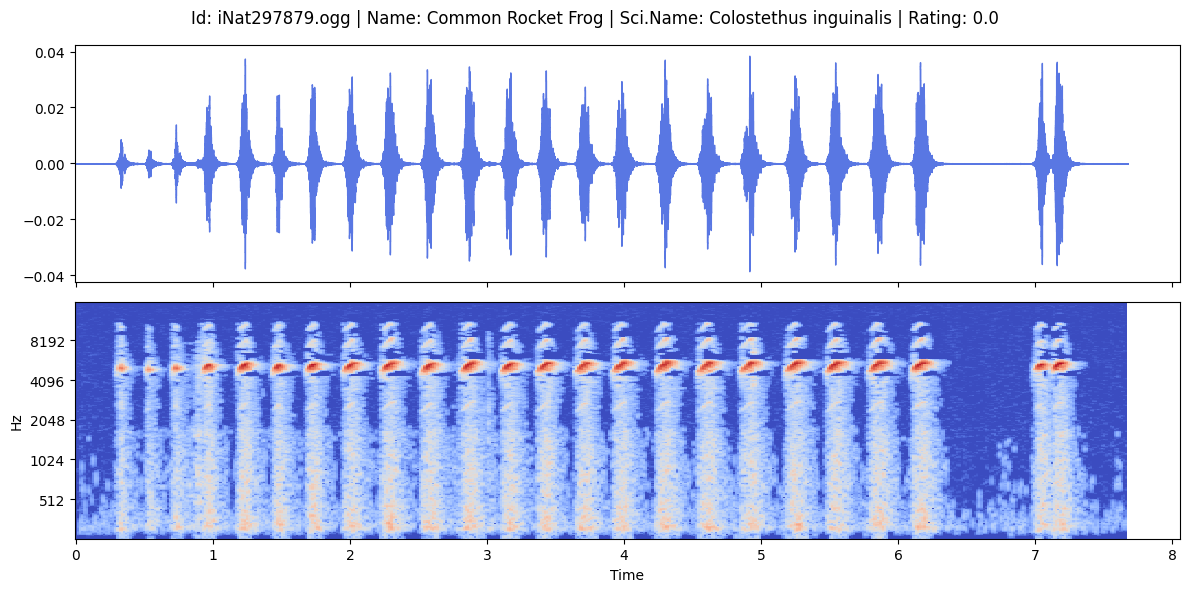

In [10]:
row = df.iloc[50]

# Display audio
display_audio(row)

# Data Split
Following code will split the data into folds using target stratification.
> **Note:** Some classess have too few samples thus not each fold contains all the classes. 

In [11]:
# Import required packages
from sklearn.model_selection import train_test_split

train_df, valid_df = train_test_split(df, test_size=0.2)

print(f"Num Train: {len(train_df)} | Num Valid: {len(valid_df)}")

Num Train: 22851 | Num Valid: 5713


# Data Loader

## Decoders

The following code will decode the raw audio from `.ogg` file and also decode the spectrogram from the `audio` file. Additionally, we will apply Z-Score standardization and Min-Max normalization to ensure consistent inputs to the model.


In [12]:
# Decodes Audio
def build_decoder(with_labels=True, dim=1024):
    def get_audio(filepath):
        file_bytes = tf.io.read_file(filepath)
        audio = tfio.audio.decode_vorbis(file_bytes)  # decode .ogg file
        audio = tf.cast(audio, tf.float32)
        if tf.shape(audio)[1] > 1:  # stereo -> mono
            audio = audio[..., 0:1]
        audio = tf.squeeze(audio, axis=-1)
        return audio

    def crop_or_pad(audio, target_len, pad_mode="constant"):
        audio_len = tf.shape(audio)[0]
        diff_len = abs(
            target_len - audio_len
        )  # find difference between target and audio length
        if audio_len < target_len:  # do padding if audio length is shorter
            pad1 = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            pad2 = diff_len - pad1
            audio = tf.pad(audio, paddings=[[pad1, pad2]], mode=pad_mode)
        elif audio_len > target_len:  # do cropping if audio length is larger
            idx = tf.random.uniform([], maxval=diff_len, dtype=tf.int32)
            audio = audio[idx : (idx + target_len)]
        return tf.reshape(audio, [target_len])

    def apply_preproc(spec):
        # Standardize
        mean = tf.math.reduce_mean(spec)
        std = tf.math.reduce_std(spec)
        spec = tf.where(tf.math.equal(std, 0), spec - mean, (spec - mean) / std)

        # Normalize using Min-Max
        min_val = tf.math.reduce_min(spec)
        max_val = tf.math.reduce_max(spec)
        spec = tf.where(
            tf.math.equal(max_val - min_val, 0),
            spec - min_val,
            (spec - min_val) / (max_val - min_val),
        )
        return spec

    def get_target(target):
        target = tf.reshape(target, [1])
        target = tf.cast(tf.one_hot(target, CFG.num_classes), tf.float32)
        target = tf.reshape(target, [CFG.num_classes])
        return target

    def decode(path):
        # Load audio file
        audio = get_audio(path)
        # Crop or pad audio to keep a fixed length
        audio = crop_or_pad(audio, dim)
        # Audio to Spectrogram
        spec = keras.layers.MelSpectrogram(
            num_mel_bins=CFG.img_size[0],
            fft_length=CFG.nfft,
            sequence_stride=CFG.hop_length,
            sampling_rate=CFG.sample_rate,
        )(audio)
        # Apply normalization and standardization
        spec = apply_preproc(spec)
        # Spectrogram to 3 channel image (for imagenet)
        spec = tf.tile(spec[..., None], [1, 1, 3])
        spec = tf.reshape(spec, [*CFG.img_size, 3])
        return spec

    def decode_with_labels(path, label):
        label = get_target(label)
        return decode(path), label

    return decode_with_labels if with_labels else decode


## Augmenters
Following code will apply augmentations to spectrogram data. In this notebook, we will use MixUp, CutOut (TimeMasking and FreqMasking) from KerasCV.

> Note that, these augmentations will be applied to batch of spectrograms rather than single spectrograms.

In [13]:
def build_augmenter():
    augmenters = [
        keras_cv.layers.MixUp(alpha=0.4),
        keras_cv.layers.RandomCutout(height_factor=(1.0, 1.0),
                                     width_factor=(0.06, 0.12)), # time-masking
        keras_cv.layers.RandomCutout(height_factor=(0.06, 0.1),
                                     width_factor=(1.0, 1.0)), # freq-masking
    ]
    
    def augment(img, label):
        data = {"images":img, "labels":label}
        for augmenter in augmenters:
            if tf.random.uniform([]) < 0.35:
                data = augmenter(data, training=True)
        return data["images"], data["labels"]
    
    return augment

## Data Pipeline
Following code builds the complete pipeline of the data flow. It uses `tf.data.Dataset` for data processing. Here are some cool features of `tf.data`,
* We can build complex input pipelines from simple, reusable pieces using`tf.data` API . For example, the pipeline for an audio model might aggregate data from files in a distributed file system, apply random transformation/augmentation to each audio/spectrogram, and merge randomly selected data into a batch for training.
* Moreover `tf.data` API provides a `tf.data.Dataset` feature that represents a sequence of components where each component comprises one or more pieces. For instance, in an audio pipeline, a component might be a single training example, with a pair of tensor pieces representing the audio and its label.

Check out this [doc](https://www.tensorflow.org/guide/data) if you want to learn more about `tf.data`.

In [14]:
def build_dataset(paths, labels=None, batch_size=32, 
                  decode_fn=None, augment_fn=None, cache=True,
                  augment=False, shuffle=2048):

    if decode_fn is None:
        decode_fn = build_decoder(labels is not None, dim=CFG.audio_len)

    if augment_fn is None:
        augment_fn = build_augmenter()
        
    AUTO = tf.data.experimental.AUTOTUNE
    slices = (paths,) if labels is None else (paths, labels)
    ds = tf.data.Dataset.from_tensor_slices(slices)
    ds = ds.map(decode_fn, num_parallel_calls=AUTO)
    ds = ds.ignore_errors()  # to avoid error temporarily
    ds = ds.cache() if cache else ds
    if shuffle:
        opt = tf.data.Options()
        ds = ds.shuffle(shuffle, seed=CFG.seed)
        opt.experimental_deterministic = False
        ds = ds.with_options(opt)
    ds = ds.batch(batch_size, drop_remainder=True)
    ds = ds.map(augment_fn, num_parallel_calls=AUTO) if augment else ds
    ds = ds.prefetch(AUTO)
    return ds

## Build Train and Valid Dataloaders

In [15]:
# Train
train_paths = train_df.filepath.values
train_labels = train_df.target.values
train_ds = build_dataset(train_paths, train_labels, batch_size=CFG.batch_size,
                         shuffle=True, augment=CFG.augment)

# Valid
valid_paths = valid_df.filepath.values
valid_labels = valid_df.target.values
valid_ds = build_dataset(valid_paths, valid_labels, batch_size=CFG.batch_size,
                         shuffle=False, augment=False)

# Visualization
To ensure our pipeline is generating **spectrogram** and its associate **label** correctly, we'll check some samples from a batch.

In [16]:
def plot_batch(batch, row=3, col=3, label2name=None,):
    """Plot one batch data"""
    if isinstance(batch, tuple) or isinstance(batch, list):
        specs, tars = batch
    else:
        specs = batch
        tars = None
    plt.figure(figsize=(col*5, row*3))
    for idx in range(row*col):
        ax = plt.subplot(row, col, idx+1)
        lid.specshow(np.array(specs[idx, ..., 0]), 
                     n_fft=CFG.nfft, 
                     hop_length=CFG.hop_length, 
                     sr=CFG.sample_rate,
                     x_axis='time',
                     y_axis='mel',
                     cmap='coolwarm')
        if tars is not None:
            label = tars[idx].numpy().argmax()
            name = label2name[label]
            plt.title(name)
    plt.tight_layout()
    plt.show()

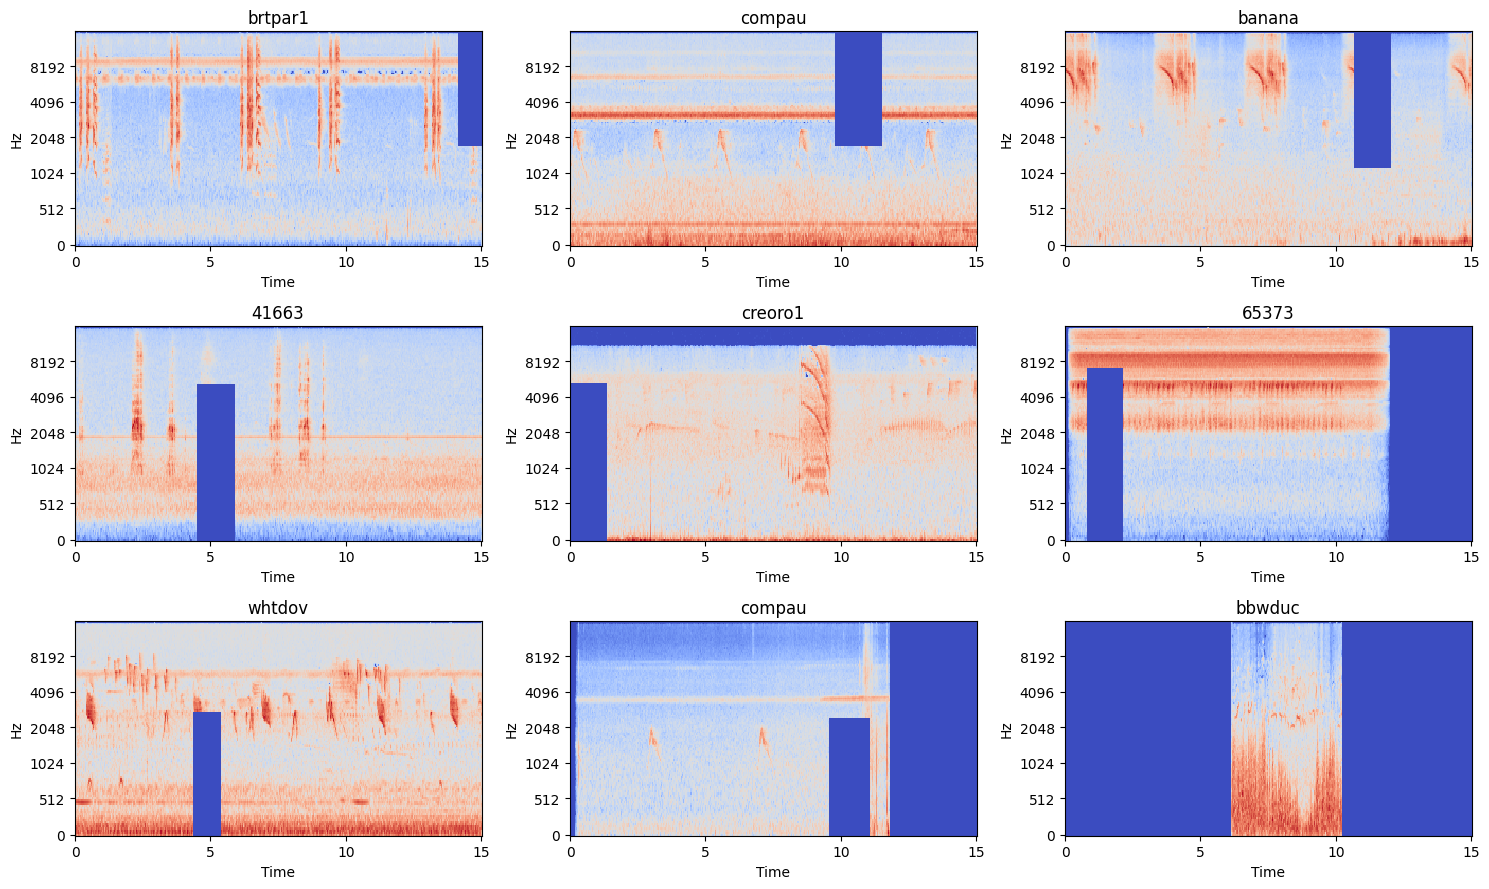

In [17]:
sample_ds = train_ds.take(100)
batch = next(iter(sample_ds))
plot_batch(batch, label2name=CFG.label2name)

# Modeling

Building a model for an audio recognition task with spectrograms as input is quite straightforward, as it is very similar to image classification. This is because the shape of spectrogram data is very similar to image data. In this notebook, to perform the audio recognition task, we will utilize the `EfficientNetV2` ImageNet-pretrained model as the backbone. Even though this backbone is pretrained with ImageNet data instead of spectrogram data, we can leverage transfer learning to adapt it to our spectrogram-based task.

> Note that we can train our model on any duration audio file (here we are using `10 seconds`), but we will always infer on `5-second` audio files (as per competition rules). To facilitate this, we have set the model input shape to `(None, None, 3)`, which will allow us to have variable-length input during training and inference.


In case you are wondering, **Why not train and infer on both `5-second`?** In the train data, we have long audio files, but we are not sure which part of the audio contains the labeled bird's song. In other words, this is weakly labeled. To ensure the provided label is accurately suited to the audio, we are using a larger audio size than `5 seconds`. You are welcome to try out different audio lengths for training.


In [18]:
# Create an input layer for the model
inp = keras.layers.Input(shape=(None, None, 3))
# Pretrained backbone
backbone = keras_cv.models.EfficientNetV2Backbone.from_preset(
    CFG.preset,
)
out = keras_cv.models.ImageClassifier(
    backbone=backbone,
    num_classes=CFG.num_classes,
    name="classifier"
)(inp)
# Build model
model = keras.models.Model(inputs=inp, outputs=out)
# Compile model with optimizer, loss and metrics
model.compile(optimizer="adam",
              loss=keras.losses.CategoricalCrossentropy(label_smoothing=0.02),
              metrics=[keras.metrics.AUC(name='auc')],
             )
model.summary()

Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'config.json' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...
Attaching 'model.weights.h5' from model 'keras/efficientnetv2/keras/efficientnetv2_b2_imagenet/2' to your Kaggle notebook...


Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, None, None, 3)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ classifier (ImageClassifier)    │ (None, 206)            │     9,059,628 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 9,059,628 (34.56 MB)

 Trainable params: 8,977,340 (34.25 MB)

 Non-trainable params: 82,288 (321.44 KB)

# LR Schedule
* Learning Rate scheduler for transfer learning. 
* The learning rate starts from `lr_start`, then decreases to a`lr_min` using different methods namely,
    * **step**: Reduce lr step wise like stair.
    * **cos**: Follow Cosine graph to reduce lr.
    * **exp**: Reduce lr exponentially.

In [19]:
import math

def get_lr_callback(batch_size=8, mode='cos', epochs=10, plot=False):
    lr_start, lr_max, lr_min = 5e-5, 8e-6 * batch_size, 1e-5
    lr_ramp_ep, lr_sus_ep, lr_decay = 3, 0, 0.75

    def lrfn(epoch):  # Learning rate update function
        if epoch < lr_ramp_ep: lr = (lr_max - lr_start) / lr_ramp_ep * epoch + lr_start
        elif epoch < lr_ramp_ep + lr_sus_ep: lr = lr_max
        elif mode == 'exp': lr = (lr_max - lr_min) * lr_decay**(epoch - lr_ramp_ep - lr_sus_ep) + lr_min
        elif mode == 'step': lr = lr_max * lr_decay**((epoch - lr_ramp_ep - lr_sus_ep) // 2)
        elif mode == 'cos':
            decay_total_epochs, decay_epoch_index = epochs - lr_ramp_ep - lr_sus_ep + 3, epoch - lr_ramp_ep - lr_sus_ep
            phase = math.pi * decay_epoch_index / decay_total_epochs
            lr = (lr_max - lr_min) * 0.5 * (1 + math.cos(phase)) + lr_min
        return lr

    if plot:  # Plot lr curve if plot is True
        plt.figure(figsize=(10, 5))
        plt.plot(np.arange(epochs), [lrfn(epoch) for epoch in np.arange(epochs)], marker='o')
        plt.xlabel('epoch'); plt.ylabel('lr')
        plt.title('LR Scheduler')
        plt.show()

    return keras.callbacks.LearningRateScheduler(lrfn, verbose=False)  # Create lr callback

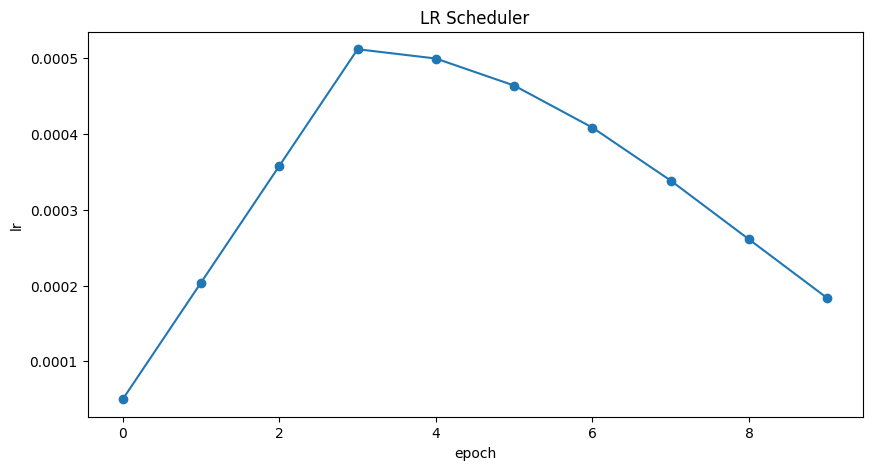

In [20]:
lr_cb = get_lr_callback(CFG.batch_size, plot=True)

# Model Checkpoint

In [21]:
ckpt_cb = keras.callbacks.ModelCheckpoint("best_model.weights.h5",
                                         monitor='val_auc',
                                         save_best_only=True,
                                         save_weights_only=True,
                                         mode='max')

# Training

In [22]:
history = model.fit(
    train_ds, 
    validation_data=valid_ds, 
    epochs=CFG.epochs,
    callbacks=[lr_cb, ckpt_cb], 
    verbose=1
)

Epoch 1/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 2606s 7s/step - auc: 0.6246 - loss: 5.1420 - val_auc: 0.7505 - val_loss: 4.7505 - learning_rate: 5.0000e-05
Epoch 2/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 80s 222ms/step - auc: 0.7639 - loss: 4.6701 - val_auc: 0.8816 - val_loss: 3.6279 - learning_rate: 2.0400e-04
Epoch 3/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - auc: 0.8316 - loss: 3.3800 - val_auc: 0.9456 - val_loss: 2.2189 - learning_rate: 3.5800e-04
Epoch 4/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - auc: 0.8587 - loss: 2.4343 - val_auc: 0.9579 - val_loss: 1.8158 - learning_rate: 5.1200e-04
Epoch 5/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 80s 223ms/step - auc: 0.8695 - loss: 1.9763 - val_auc: 0.9625 - val_loss: 1.6287 - learning_rate: 4.9972e-04
Epoch 6/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 79s 219ms/step - auc: 0.8776 - loss: 1.7044 - val_auc: 0.9621 - val_loss: 1.5394 - learning_rate: 4.6406e-04
Epoch 7/10
356/356 ━━━━━━━━━━━━━━━━━━━━ 80s 222ms/step - auc: 0.8834 - loss: 1.5085 - val_auc: 0.9632 - val

## Result Summary

In [23]:
best_epoch = np.argmax(history.history["val_auc"])
best_score = history.history["val_auc"][best_epoch]
print('>>> Best AUC: ', best_score)
print('>>> Best Epoch: ', best_epoch+1)

>>> Best AUC:  0.9631980061531067
>>> Best Epoch:  7
